In [1]:
from datasets import load_dataset
#load the mnist dataset from HuggingFace datasets and convert the format to "torch"
dataset = load_dataset("ylecun/mnist").with_format("torch")

#split the training and testing datasets
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import default_collate, RandomSampler, SequentialSampler

torch.manual_seed(0)

#defining samplers
# Since datasets is a Map-style dataset, we can setup a sampler to shuffle the data
train_sampler = RandomSampler(train_dataset)
test_sampler = RandomSampler(test_dataset)

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


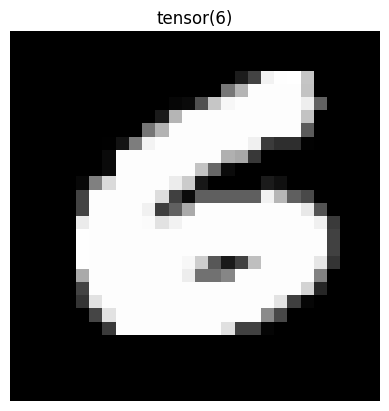

In [3]:
#Let's display one image and the corresponding label
from utils import display_mnist_sample
display_mnist_sample(train_dataset)

In [4]:
# Now we can set up some torchdata.nodes to create our pre-proc pipeline
from torchdata.nodes import MapStyleWrapper, ParallelMapper, Batcher, PinMemory, Loader

# All torchdata.nodes.BaseNode implementations are Iterators.
# MapStyleWrapper creates an Iterator that combines sampler and train_dataset to create an iterator.
#
# Under the hood, MapStyleWrapper just does:
# > node = IterableWrapper(sampler)
# > node = Mapper(node, map_fn=train_dataset.__getitem__)  # You can parallelize this with ParallelMapper

node = MapStyleWrapper(map_dataset=train_dataset, sampler=train_sampler)

# Now we want to transform the raw inputs. We can just use another Mapper with
# a custom map_fn to perform this. Using ParallelMapper allows us to use multiple
# threads (or processes) to parallelize this work and have it run in the background
#We need a mapper function to convert a dtype and also normalize
def map_fn(item):
    image = item["image"].to(torch.float32)/255
    label = item["label"]

    return {"image":image, "label":label}
node = ParallelMapper(node, map_fn=map_fn, num_workers=2) # output items are Dict[str, tensor]


# Hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001
num_classes = 10
# Next we batch the inputs, and then apply a collate_fn with another Mapper
# to stack the tensors between. We use torch.utils.data.default_collate for this
node = Batcher(node, batch_size=batch_size) # output items are List[Dict[str, tensor]]
node = ParallelMapper(node, map_fn=default_collate, num_workers=2) # outputs are Dict[str, tensor]

# we can optionally apply pin_memory to the batches
if torch.cuda.is_available():
    node = PinMemory(node)

# Since nodes are iterators, they need to be manually .reset() between epochs.
# We can wrap the root node in Loader to convert it to a more conventional Iterable.
train_loader = Loader(node)



In [5]:
#We apply similar transformations to the test_dataset
node = MapStyleWrapper(map_dataset=test_dataset, sampler=test_sampler)
node = ParallelMapper(node, map_fn=map_fn, num_workers=2) 
node = Batcher(node, batch_size=batch_size) 
node = ParallelMapper(node, map_fn=default_collate, num_workers=2) 

if torch.cuda.is_available():
    node = PinMemory(node)

test_loader = Loader(node)

In [6]:
# Next we load the NN model
from utils import MNIST_Net
model = MNIST_Net().to("cpu")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from utils import train_mnist_model
model, loss_list, accuracy_list = train_mnist_model(model, num_epochs, train_loader, test_loader, loss_fn, optimizer)


Test Accuracy: 98.23717948717949 %


In [7]:
#plotting train_loss and test_accuracy
import matplotlib.pyplot as plt

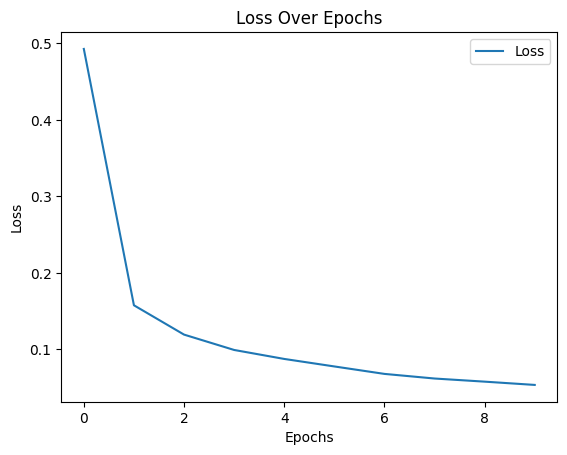

In [8]:
plt.plot(loss_list, label='Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

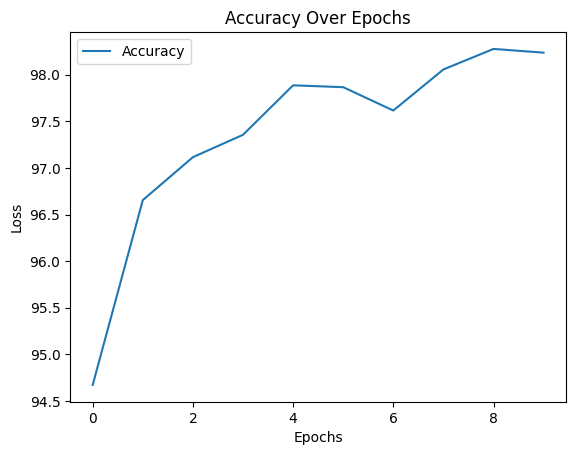

In [9]:
plt.plot(accuracy_list, label='Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()